##Data Loading/Imports

In [47]:
!pip install medmnist

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
import numpy as np


In [49]:
import medmnist
from medmnist import INFO, DermaMNIST
import matplotlib.pyplot as plt

##Basic Data Information

In [50]:
# Load all three splits
train_data = DermaMNIST(split='train', download=True)
val_data = DermaMNIST(split='val', download=True)
test_data = DermaMNIST(split='test', download=True)

# Print the size of each to confirm they loaded
print(f"Train samples: {len(train_data)}")
print(f"Val samples:   {len(val_data)}")
print(f"Test samples:  {len(test_data)}")


Train samples: 7007
Val samples:   1003
Test samples:  2005


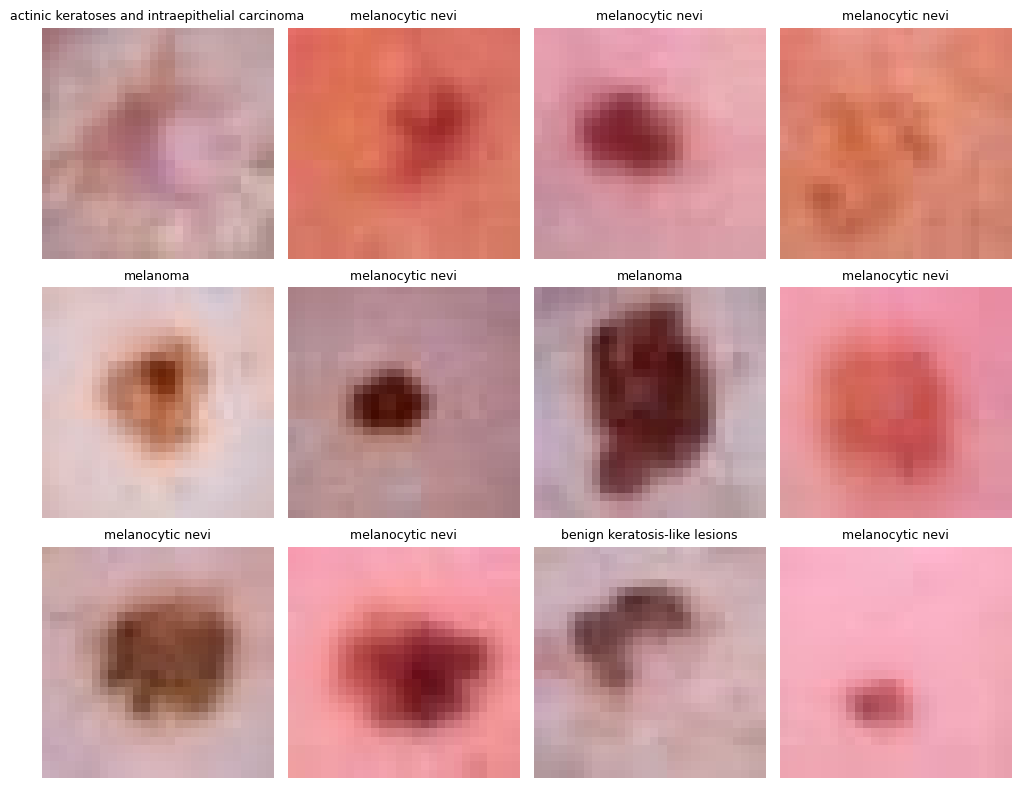

In [51]:
import matplotlib.pyplot as plt
from medmnist import INFO

# Get the label names (e.g., 'melanoma', 'basal cell carcinoma')
info = INFO['dermamnist']
label_names = info['label']

# Plot a grid of images
plt.figure(figsize=(10, 8))

for i in range(12):
    # Get image and label index
    img, label = train_data[i]

    # Create a subplot for each image
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)

    # Get the actual name of the disease from the label index
    label_text = label_names[str(label[0])]
    plt.title(label_text, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


#Basics to learn

In [52]:
from torchvision import transforms

# This is the "Everything Bagel" of transforms.
# It applies every single effect we discussed in sequence.
learning_transforms = transforms.Compose([

    # --- 1. RESIZING & SHAPE ---
    # Makes the tiny 28x28 image larger (64x64). Good for seeing details.
    transforms.Resize((64, 64)),

    # --- 2. RANDOM FLIPS ---
    # 50% chance to flip horizontally (mirror) or vertically (upside down).
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    # --- 3. ROTATION ---
    # Spins the image randomly anywhere between -45 and +45 degrees.
    transforms.RandomRotation(degrees=45),

    # --- 4. COLOR & LIGHTING (JITTER) ---
    # Randomly changes Brightness, Contrast, Saturation, and Hue by up to 20%.
    # This is the "Jitter" that simulates different cameras/lighting.
    transforms.ColorJitter(brightness=0.9, contrast=0.2, saturation=0.2, hue=0.1),

    # --- 5. STYLE & BLUR ---
    # Turns it Black & White (but keeps 3 channels so the model doesn't crash).
    transforms.Grayscale(num_output_channels=3),

    # Blurs the image slightly (like a shaky hand holding a camera).
    transforms.GaussianBlur(kernel_size=3),

    # --- 6. CROPPING ---
    # Zooms in and grabs a random 50x50 area from the resized 64x64 image.
    transforms.RandomCrop(50),

    # --- 7. THE MATH (MANDATORY) ---
    # Converts the edited picture into a Tensor (math grid) for the computer.
    transforms.ToTensor(),

    # Centers all the pixel math around zero so the CNN trains faster.
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [53]:
# from PIL import Image
# import numpy as np

# plt.figure(figsize=(12, 10))

# for i in range(12):
#     # 1. Get the raw numpy array from medmnist
#     raw_array = train_dataset.imgs[i]

#     # 2. FIX: Convert the numpy array to a PIL Image first
#     # This is what transforms.Resize and others expect!
#     pil_img = Image.fromarray(raw_array)

#     # 3. Apply your math transforms
#     math_img = learning_transforms(pil_img)

#     plt.subplot(3, 4, i + 1)

#     # Use our previous helper to show the math
#     # (Un-normalizes and permutes channels)
#     imshow_math(math_img)

#     # Get labels (squeeze() is used because medmnist labels are 2D arrays)
#     label_idx = train_dataset.labels[i].item()
#     label_text = info['label'][str(label_idx)]

#     plt.title(label_text, fontsize=8)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()



# Test different Models (linear, mlp, cnn, resnet, vit)

In [54]:
#basic dataloading and setups

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [56]:
data_flag = 'pathmnist'
info = INFO[data_flag]
num_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


In [57]:
#training and eval

In [58]:
def train_model(model, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


In [59]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total


##Baseline Models

In [60]:
#linear model

A linear model is the simplest approach/visualization. It takes the image and transforms it into a long list of pixel values by flattening into a 1-demensional vector. The model learns this single linear equation by combining all the pixel values to produce a prediction. It can only capture basic patterns like brightness and colors, not shapes or edges or anything. This causes linear models to perform poorly overall, but are a good baseline.

In [61]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28*3, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [62]:
model_linear = LinearModel().to(device)
optimizer = optim.Adam(model_linear.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(model_linear, optimizer, criterion)
acc_linear = evaluate_model(model_linear)
print("Linear Accuracy:", acc_linear)


Epoch 1/10, Loss: 1.9351
Epoch 2/10, Loss: 1.8399
Epoch 3/10, Loss: 1.8109
Epoch 4/10, Loss: 1.7994
Epoch 5/10, Loss: 1.7897
Epoch 6/10, Loss: 1.7817
Epoch 7/10, Loss: 1.7795
Epoch 8/10, Loss: 1.7614
Epoch 9/10, Loss: 1.7592
Epoch 10/10, Loss: 1.7576
Linear Accuracy: 0.3597493036211699


In [63]:
#MLP

MLP means multi-layer perceptron and its a little bit more advanced than a linear model but pretty similar overall. Similar to a linear model, it takes the images and flattens them, but it is able to learn more complex pixels. It can capture nonlinear patterns that linear can't, but still struggles with images and can't correlate nearby pixels with eachother.

In [64]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [65]:
model_mlp = MLP().to(device)
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)

train_model(model_mlp, optimizer, criterion)
acc_mlp = evaluate_model(model_mlp)
print("MLP Accuracy:", acc_mlp)


Epoch 1/10, Loss: 1.7019
Epoch 2/10, Loss: 1.4251
Epoch 3/10, Loss: 1.3423
Epoch 4/10, Loss: 1.3057
Epoch 5/10, Loss: 1.2784
Epoch 6/10, Loss: 1.2502
Epoch 7/10, Loss: 1.2172
Epoch 8/10, Loss: 1.1960
Epoch 9/10, Loss: 1.1771
Epoch 10/10, Loss: 1.1460
MLP Accuracy: 0.5473537604456824


In [66]:
#CNN - classic baseline model

Stands for convolutional nueral network, it is a classic model for being able to understand images in the forms of pixels. Instead of flattening the pixels, it keeps them 2-dimensional. How it works: it uses small filters to slide across the images and detect patters like edges, corners, and textures. All these layers are then combined across layers to form more advanced representations of shapes/objects. Since filters cover the full image, the model is good at recognizing objects regardless of where they are (unlike linear and mlp), which means its way more effective.

In [67]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [68]:
model_cnn = SimpleCNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

train_model(model_cnn, optimizer, criterion)
acc_cnn = evaluate_model(model_cnn)
print("CNN Accuracy:", acc_cnn)


Epoch 1/10, Loss: 1.0864
Epoch 2/10, Loss: 0.7876
Epoch 3/10, Loss: 0.6899
Epoch 4/10, Loss: 0.6187
Epoch 5/10, Loss: 0.5767
Epoch 6/10, Loss: 0.5423
Epoch 7/10, Loss: 0.5129
Epoch 8/10, Loss: 0.4820
Epoch 9/10, Loss: 0.4603
Epoch 10/10, Loss: 0.4382
CNN Accuracy: 0.7920612813370473


In [69]:
#ResNet

Stands for residual network, and is a more powerful version of cnn. Some network models have issues with training due to vanishing gradients, and resnet solves this by using skip connections. It allows information to bypass certain layers. It helps the model learn and stabalize training, even when theres a lot of layers. As a result, resnet can learn very detailed images and are even stronger than cnn.

In [70]:
from torchvision.models import resnet18

model_resnet = resnet18(pretrained=False)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet = model_resnet.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [71]:
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3)

train_model(model_resnet, optimizer, criterion)
acc_resnet = evaluate_model(model_resnet)
print("ResNet Accuracy:", acc_resnet)


Epoch 1/10, Loss: 0.7293
Epoch 2/10, Loss: 0.4866
Epoch 3/10, Loss: 0.3748
Epoch 4/10, Loss: 0.3122
Epoch 5/10, Loss: 0.2680
Epoch 6/10, Loss: 0.2363
Epoch 7/10, Loss: 0.2162
Epoch 8/10, Loss: 0.1938
Epoch 9/10, Loss: 0.1785
Epoch 10/10, Loss: 0.1670
ResNet Accuracy: 0.5409470752089136


In [72]:
#ViT

Stands for Vision Transformer, and it takes a completly different approach then cnn and resnet. Instead of looking at local pixels it divides the image into patches and treats each patch as a token (like words in a sentence). Then it allows every patch to interact with eachother giving the model a strong ability to model gloabl relationships across the entire image. Since they are so advanced, they require large amounts of data/pretraining to perform well. Not as good for smaller datasets like cnn and resnet would be.

In [73]:
import timm

model_vit = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False,
    num_classes=num_classes
)
model_vit = model_vit.to(device)


In [74]:
#needs tvo reshape images for ViT to 224x224
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [75]:
train_dataset.transform = transform_vit
test_dataset.transform = transform_vit


In [ ]:
optimizer = optim.Adam(model_vit.parameters(), lr=3e-4)

train_model(model_vit, optimizer, criterion)
acc_vit = evaluate_model(model_vit)
print("ViT Accuracy:", acc_vit)


### Compare Models

In [1]:
results = {
    "Linear": acc_linear,
    "MLP": acc_mlp,
    "CNN": acc_cnn,
    "ResNet": acc_resnet,
    "ViT": acc_vit
}

for k, v in results.items():
    print(f"{k}: {v:.4f}")


NameError: name 'acc_linear' is not defined